In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
import matplotlib.pyplot as plt
from keras import regularizers
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input

Using TensorFlow backend.


In [2]:
#train
#test
#load data
path = 'C:/Users/mys12/Desktop/northeastern/summer2018/data_Robust_Fingerprinting-master/DISTRIBUTED_OPENSOURCE/FINGERPRINTING_DB'

test_rss = pd.read_csv(path + '/Training_rss_21Aug17.csv', header = 0)
test_coord = pd.read_csv(path + '/Training_coordinates_21Aug17.csv', header = 0)
test_rss = test_rss.replace(100, 0)

train_rss = pd.read_csv(path + '/Test_rss_21Aug17.csv', header = 0)
train_coord = pd.read_csv(path + '/Test_coordinates_21Aug17.csv', header = 0)
train_rss = train_rss.replace(100, 0)

In [3]:
train_rss.head()

,100,100.1,100.2,100.3,100.4,100.5,100.6,100.7,100.8,100.9,...,100.939,100.940,100.941,100.942,100.943,100.944,100.945,100.946,100.947,100.948
0,0,0,0,0,0,0,0,-64,0,-64,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train = pd.concat([train_rss, train_coord], axis=1, ignore_index=True)
test = pd.concat([test_rss, test_coord], axis=1, ignore_index=True)
train = np.asarray(train)
test = np.asarray(test)

# first floor
train1 = train[train[:,-1]==0.0]
normalizer = preprocessing.Normalizer(norm='l1').fit(train1[:,:-4])
train1_r=normalizer.transform(train1[:,:-3])
train1_c=train1[:,-3:-1]
train1_r.shape

test1 = test[test[:,-1]==0.0]
test1_r=normalizer.transform(test1[:,:-4])
test1_c=test1[:,-3:-1]


# second floor
train2 = train[train[:,-1]==3.7]
train2_r=scale(train2[:,:-3])
train2_c=train2[:,-3:-1]

test2 = test[test[:,-1]==3.7]
test2_r=scale(test2[:,:-3])
test2_c=test2[:,-3:-1]

# third floor
train3 = train[train[:,-1]==7.4]
train3_r=train3[:,:-3]
train3_c=train3[:,-3:-1]

test3 = test[test[:,-1]==7.4]
test3_r=scale(test2[:,:-3])
test3_c=test2[:,-3:-1]

# forth floor
train4 = train[train[:,-1]==11.1]
train4_r=train4[:,:-3]
train4_c=train4[:,-3:-1]

test4 = test[test[:,-1]==11.1]
test4_r=scale(test4[:,:-3])
test4_c=test4[:,-3:-1]

# fifth floor
train5 = train[train[:,-1]==14.8]
train5_r=train5[:,:-3]
train5_c=train5[:,-3:-1]

test5 = test[test[:,-1]==14.8]
test5_r=scale(test4[:,:-3])
test5_c=test5[:,-3:-1]

In [5]:
train1_c[0:5]
num_input = train1_r.shape[1]
print(num_input)

992


In [6]:
def predata(rss, locations):
    # the origin of the room
    origin = np.amin(locations,axis=0)
    #size of the room
    room_size = np.amax(locations, axis=0)-origin
    # position respect to origin
    train_Yy = locations - origin
    train_Xx = np.asarray(rss, dtype=np.float64)
    return train_Xx, train_Yy

In [7]:
def plotpre(train_r,train_c):
    train1_X, train1_Y = predata(train1_r, train1_c)
    x,y= train1_Y.T
    return x, y

In [8]:
def train_val(rss, locations):
    train_Xx, train_Yy = predata(rss, locations)
    train_x, val_x, train_y, val_y = train_test_split(train_Xx, train_Yy, test_size=0.25)
    return train_x, val_x, train_y, val_y

In [9]:
def accuracy(predictions, labels):
    error = np.sqrt(np.sum((predictions - labels)**2, 1))
    return error, np.mean(error)

In [169]:
def train_model(rss, locations, test_rss, test_locations):
    # get train_X, val_X, train_Y, val_Y
    train_X, val_X, train_Y, val_Y = train_val(rss, locations)
    test_X, test_Y = predata(test_rss, test_locations)
    
    # parameters
    num_input = train_X.shape[1]# input layer size
    act_fun = 'relu'
    regularzation_penalty = 0.03
    initilization_method = 'he_normal' #'random_uniform' ,'random_normal','TruncatedNormal' ,'glorot_uniform', 'glorot_nomral', 'he_normal', 'he_uniform'
    #Optimizer
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    # define model

    model = Sequential()
    model.add(Dense(512, activation=act_fun, input_dim=num_input, kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation=act_fun, kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))
    model.add(Dropout(0.5))
#     model.add(Dense(128, activation=act_fun, kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))
#     model.add(Dropout(0.5))
    model.add(Dense(2, activation='linear', kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))

    #Model compile
    model.compile(loss='mean_squared_error',
                  optimizer=adam)
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')
    model.fit(train_X, train_Y,
              epochs=1000,
              batch_size=64,callbacks=[earlyStopping],validation_data=(val_X, val_Y))#tbCallBack,
    #model evaluate
    train_loss = model.evaluate(train_X,train_Y, batch_size=len(train_Y)) #calculate the data in test mode(Keras)
    val_loss = model.evaluate(val_X, val_Y, batch_size=len(val_Y))
    test_loss = model.evaluate(test_X, test_Y, batch_size=len(test_Y))
    print("Loss for training data is",train_loss)
    print("Loss for validation data is",val_loss)
    print("Loss for test data is",test_loss)
    predict_Y = model.predict(test_X)
    error_t, accuracy_t = accuracy(predict_Y, test_Y)
    return predict_Y, error_t, accuracy_t

In [170]:
predict1, error, accuracy1 = train_model(train1_r, train1_c, test1_r, test1_c)



Train on 948 samples, validate on 316 samples
Epoch 1/1000
948/948 [==============================] - 2s - loss: 4704.8767 - val_loss: 4628.3437
Epoch 2/1000
948/948 [==============================] - 0s - loss: 4629.1117 - val_loss: 4500.4947
Epoch 3/1000
948/948 [==============================] - 0s - loss: 4423.8621 - val_loss: 4183.7195
Epoch 4/1000
948/948 [==============================] - 0s - loss: 3974.6695 - val_loss: 3567.0133
Epoch 5/1000
948/948 [==============================] - 0s - loss: 3185.4014 - val_loss: 2638.4005
Epoch 6/1000
948/948 [==============================] - 0s - loss: 2183.6122 - val_loss: 1641.7490
Epoch 7/1000
948/948 [==============================] - 0s - loss: 1317.4762 - val_loss: 985.9749
Epoch 8/1000
948/948 [==============================] - 0s - loss: 838.9902 - val_loss: 652.4976
Epoch 9/1000
948/948 [==============================] - 0s - loss: 594.3403 - val_loss: 514.0273
Epoch 10/1000
948/948 [==============================] - 0s - loss: 

948/948 [==============================] - 0s - loss: 143.4827 - val_loss: 115.4350
Epoch 167/1000
948/948 [==============================] - 0s - loss: 142.5514 - val_loss: 112.2814
Epoch 168/1000
948/948 [==============================] - 0s - loss: 142.9367 - val_loss: 112.3166
Epoch 169/1000
948/948 [==============================] - 0s - loss: 140.0688 - val_loss: 113.7012
Epoch 170/1000
948/948 [==============================] - 0s - loss: 142.0701 - val_loss: 112.0389
Epoch 171/1000
948/948 [==============================] - 0s - loss: 140.6325 - val_loss: 111.0822
Epoch 172/1000
948/948 [==============================] - 0s - loss: 138.8575 - val_loss: 112.6352
Epoch 173/1000
948/948 [==============================] - 0s - loss: 139.1340 - val_loss: 110.7016
Epoch 174/1000
948/948 [==============================] - 0s - loss: 135.9778 - val_loss: 110.1231
Epoch 175/1000
948/948 [==============================] - 0s - loss: 135.1776 - val_loss: 115.2836
Epoch 176/1000
948/948 [=

948/948 [==============================] - 0s - loss: 122.1741 - val_loss: 98.3757
Epoch 332/1000
948/948 [==============================] - 0s - loss: 118.1906 - val_loss: 101.4752
Epoch 333/1000
948/948 [==============================] - 0s - loss: 122.9739 - val_loss: 97.0498
Epoch 334/1000
948/948 [==============================] - 0s - loss: 121.3745 - val_loss: 99.7218
Epoch 335/1000
948/948 [==============================] - 0s - loss: 114.9673 - val_loss: 97.8679
Epoch 336/1000
948/948 [==============================] - 0s - loss: 121.5300 - val_loss: 100.9687
Epoch 337/1000
948/948 [==============================] - 0s - loss: 120.6766 - val_loss: 99.0820
Epoch 338/1000
948/948 [==============================] - 0s - loss: 116.2155 - val_loss: 98.5355
Epoch 339/1000
948/948 [==============================] - 0s - loss: 123.6518 - val_loss: 104.4100
Epoch 340/1000
948/948 [==============================] - 0s - loss: 122.4118 - val_loss: 97.8929
Epoch 341/1000
948/948 [========

948/948 [==============================] - 0s - loss: 111.7179 - val_loss: 94.7728
Epoch 498/1000
948/948 [==============================] - 0s - loss: 108.6220 - val_loss: 92.6673
Epoch 499/1000
948/948 [==============================] - 0s - loss: 114.1579 - val_loss: 92.1034
Epoch 500/1000
948/948 [==============================] - 0s - loss: 112.8154 - val_loss: 90.0220
Epoch 501/1000
948/948 [==============================] - 0s - loss: 104.8593 - val_loss: 90.6076
Epoch 502/1000
948/948 [==============================] - 0s - loss: 107.8329 - val_loss: 91.6823
Epoch 503/1000
948/948 [==============================] - 0s - loss: 108.0328 - val_loss: 90.4736
Epoch 504/1000
948/948 [==============================] - 0s - loss: 109.6575 - val_loss: 93.9941
Epoch 505/1000
948/948 [==============================] - 0s - loss: 109.9827 - val_loss: 91.9547
Epoch 506/1000
948/948 [==============================] - 0s - loss: 110.7560 - val_loss: 92.0626
Epoch 507/1000
948/948 [===========

948/948 [==============================] - 0s - loss: 109.2332 - val_loss: 89.7245
Epoch 664/1000
948/948 [==============================] - 0s - loss: 102.0156 - val_loss: 87.4516
Epoch 665/1000
948/948 [==============================] - 0s - loss: 102.4388 - val_loss: 86.4714
Epoch 666/1000
948/948 [==============================] - 0s - loss: 105.2812 - val_loss: 89.7322
Epoch 667/1000
948/948 [==============================] - 0s - loss: 106.1364 - val_loss: 85.6931
Epoch 668/1000
948/948 [==============================] - 0s - loss: 103.1010 - val_loss: 85.3733
Epoch 669/1000
948/948 [==============================] - 0s - loss: 107.8560 - val_loss: 85.7740
Epoch 670/1000
948/948 [==============================] - 0s - loss: 103.9697 - val_loss: 86.5445
Epoch 671/1000
948/948 [==============================] - 0s - loss: 106.3912 - val_loss: 87.5569
Epoch 672/1000
948/948 [==============================] - 0s - loss: 103.8055 - val_loss: 86.0235
Epoch 673/1000
948/948 [===========

948/948 [==============================] - 0s - loss: 99.7119 - val_loss: 81.8680
Epoch 831/1000
948/948 [==============================] - 0s - loss: 96.8337 - val_loss: 85.8294
Epoch 832/1000
948/948 [==============================] - 0s - loss: 101.6763 - val_loss: 85.5092
Epoch 833/1000
948/948 [==============================] - 0s - loss: 98.9434 - val_loss: 82.2094
Epoch 834/1000
948/948 [==============================] - 0s - loss: 95.3687 - val_loss: 83.1167
Epoch 835/1000
948/948 [==============================] - 0s - loss: 97.4267 - val_loss: 81.2648
Epoch 836/1000
948/948 [==============================] - 0s - loss: 99.7664 - val_loss: 82.0349
Epoch 837/1000
948/948 [==============================] - 0s - loss: 99.8222 - val_loss: 82.0622
Epoch 838/1000
948/948 [==============================] - 0s - loss: 95.1632 - val_loss: 83.4034
Epoch 839/1000
948/948 [==============================] - 0s - loss: 99.8973 - val_loss: 82.5041
Epoch 840/1000
948/948 [====================

948/948 [==============================] - 0s - loss: 96.1500 - val_loss: 79.1806
Epoch 999/1000
948/948 [==============================] - 0s - loss: 95.4687 - val_loss: 79.9765
Epoch 1000/1000
226/226 [==============================] - 0s
Loss for training data is 55.6273994446
Loss for validation data is 80.4739151001
Loss for test data is 109.512710571


In [171]:
print('The average error:', accuracy1)

The average error: 9.71187968549


In [172]:
print('minimum error:', np.amin(error), 'maximum error:', np.amax(error), 'variance:', np.var(error))

minimum error: 0.512018594564 maximum error: 95.0999141293 variance: 65.8952158261


In [173]:
np.median(error)

8.6555265487118422

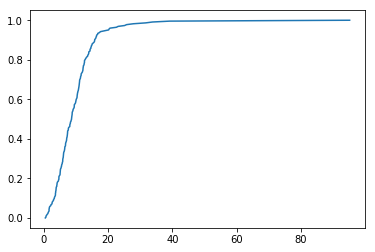

In [174]:
error_sorted= np.sort(error)
p = 1. *np.arange(len(error))/(len(error)-1)
plt.plot(error_sorted, p)
plt.show()

In [23]:
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input
def cnn_model(rss, locations, test_rss, test_locations):
    # get train_X, val_X, train_Y, val_Y
    train_X, val_X, train_Y, val_Y = train_val(rss, locations)
    test_X, test_Y = predata(test_rss, test_locations)
    
    # parameters
    num_input = train_X.shape[1]# input layer size
    act_fun = 'relu'
    regularzation_penalty = 0.03
    initilization_method = 'he_normal' #'random_uniform' ,'random_normal','TruncatedNormal' ,'glorot_uniform', 'glorot_nomral', 'he_normal', 'he_uniform'
    #Optimizer
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')
    
    train_X.reshape((1,train_X.shape[0],train_X.shape[1]))
    test_X.reshape((1,test_X.shape[0],test_X.shape[1]))
    val_X.reshape((1,val_X.shape[0],val_X.shape[1]))
    
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3,activation='relu',input_shape = (train_X.shape[1],num_input)))
    model.add(Conv1D(filters=32, kernel_size=2,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='mean_squared_error',
                  optimizer=adam, metrics=['accuracy'])          
    model.fit(train_X, train_Y,
              epochs=1000,
              batch_size=64,callbacks=[earlyStopping],validation_data=(val_X, val_Y))#tbCallBack,
    train_loss = model.evaluate(train_X,train_Y, batch_size=len(train_Y)) #calculate the data in test mode(Keras)
    val_loss = model.evaluate(val_X, val_Y, batch_size=len(val_Y))
    test_loss = model.evaluate(test_X, test_Y, batch_size=len(test_Y))
    print(model.summary())
    print("Loss for training data is",train_loss)
    print("Loss for validation data is",val_loss)
    print("Loss for test data is",test_loss)
    predict_Y = model.predict(test_X)
    error_t, accuracy_t = accuracy(predict_Y, test_Y)
    return predict_Y, error_t, accuracy_t           
              

In [24]:
predict1_cnn, error_cnn, accuracy1_cnn = cnn_model(train1_r, train1_c, test1_r, test1_c)

ValueError: Error when checking input: expected conv1d_9_input to have 3 dimensions, but got array with shape (948, 992)

In [ ]:
print('The average error:', accuracy1_cnn)
print('minimum error:', np.amin(error_cnn), 'maximum error:', np.amax(error_cnn), 'variance:', np.var(error_cnn))

In [ ]:
error_sortedcnn= np.sort(error_cnn)
p1 = 1. *np.arange(len(error_cnn))/(len(error_cnn)-1)
plt.plot(error_sortedcnn, p1)
plt.show()